In [48]:
import lorm
from nfft import nfft
import disc.energy_curveling_3d
import numpy as np
from pythreejs import *
from itertools import product
import matplotlib.pyplot as plt

In [118]:
def sampleCircle(num):
    t = np.linspace(0,2*np.pi,num,endpoint=False)
    coords = np.zeros([num,3])
    coords[:,1] = np.cos(t)
    coords[:,0] = np.sin(t)
    coords[:,2] = 0
    return coords

In [369]:
#mu_m = 20
#mu = 0.4*sampleCircle(mu_m) + 0.1*(np.random.rand(mu_m,3)-0.5)
mu = 0.3*np.array([[0,1,1],[-1,0,1],[0,-1,1],[1,0,1],[1,1,-1],[-1,1,-1],[-1,-1,-1],[1,-1,-1]])
mu = mu - 0.5*np.array([0,0,1])
mu[4:8,:] = mu[4:8,:] + np.array([0,0,1])

mu_m = mu.shape[0]

mu_N_half = 64
nfft3d = nfft.NFFT3D(mu_m,2*mu_N_half,2*mu_N_half,2*mu_N_half)
nfft3d.x = mu
nfft3d.precompute_x()
nfft3d.f = np.ones(mu_m,dtype=np.complex)/mu_m
nfft3d.adjoint()
mu_hat = np.zeros([2*mu_N_half,2*mu_N_half,2*mu_N_half],dtype=np.complex)
mu_hat[:] = nfft3d.f_hat/nfft3d.f_hat[mu_N_half,mu_N_half,mu_N_half]

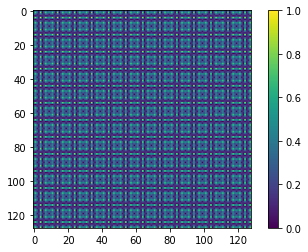

In [370]:
%matplotlib inline
plt.imshow(np.abs(mu_hat)[:,:,mu_N_half])
plt.colorbar()

In [699]:
e3 = lorm.manif.EuclideanSpace(3)
points = lorm.manif.ManifoldPointArray(e3)
points.coords = 0.2*sampleCircle(40)

In [700]:
N_half = 16
N=2*N_half
m = points.coords.shape[0]
energy = disc.energy_curveling_3d.plan(m,N,0.5,1)
if mu_N_half >= N_half:
    energy._mu_hat[:] = mu_hat[mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half]
else:
    energy._mu_hat[N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half] = mu_hat[:]
#energy._mu_hat[0,:,:] = 0
#energy._mu_hat[:,0,:] = 0
#energy._mu_hat[:,:,0] = 0

In [701]:
energy._lambda_hat = np.ones([N,N,N])
for i in range(N):
    for j in range(N):
        for k in range(N):
            norm_squared = (i-N/2)**2+(j-N/2)**2+(k-N/2)**2
            energy._lambda_hat[i,j,k] = 1./np.power(norm_squared+1,4)

In [702]:
# interactive rendering setup
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords, normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

children = [line1]#, sphere, c,  AmbientLight(color='#FFFFFF')]
for p in mu:
    for x in ((0,0,0)):#,(0,0,1)):#product(range(-1,2),repeat=3):
        point = Mesh(SphereBufferGeometry(0.01,1,1), MeshStandardMaterial(color='blue'))
        px = p+np.array(x)
        if(np.linalg.norm(px,np.inf)<1):
            point.position = (px[0],px[1],px[2]) 
            children.append( point )

scene = Scene(children=children)#[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

def update_points(p):
    g1.attributes['position'].array = p.coords

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [703]:
energy._alpha = 1
energy._L = 1
method= lorm.optim.ConjugateGradientMethod(max_iter=10,tol_grad=1e-12)
method.listener = update_points
for i in range(2):
    points = method.run(energy,points)

Initial value: f[0] = 0.30860634512220286
f[1] = 0.2968253026311485
f[2] = 0.29671502734508004
f[3] = 0.2956012515253729
f[4] = 0.289984687177564
f[5] = 0.2896647748255555
f[6] = 0.2885471877134891
f[7] = 0.2868683539915123
f[8] = 0.28641304526318373
f[9] = 0.285960004074372
f[10] = 0.2859028894461682
Reached maximal iterations!
Initial value: f[0] = 0.2859028894461682
f[1] = 0.2858747481437266
f[2] = 0.2858190948838987
f[3] = 0.28579340704494505
f[4] = 0.2857737594511424
f[5] = 0.28574369812967493
f[6] = 0.28573549014903427
f[7] = 0.2856841598021361
f[8] = 0.2856763684643051
f[9] = 0.285651492559177
f[10] = 0.2856461337866002
Reached maximal iterations!


1


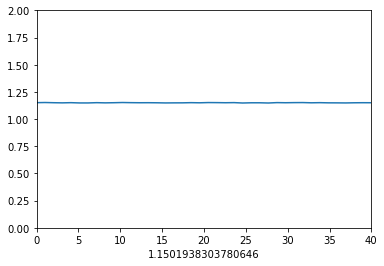

In [704]:
fig = plt.figure()
bx = fig.add_subplot(111)
bx.axis(np.array([0,m,0,2*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.coords))
bx.add_line(distance)
print(energy._L)